# Negative mood detection in Tweets
### Combined two approaches: automatic model training and rule-based lexicon analysis
### Text processing: spelling correction, stop word/punctuation removal,lemmatization
### Train model to detect negative mode (SGDClassifier, LogisticRegression, MultinomialNB, LinearSVC on tfidf matrix)
### Text analysis: wordcloud, sentiment polarity analysis (TextBlob, Pattern, Opinion lexicon and SentiWords)
### Ensemble learning (Max voting, blending and stacking) didn't improve the performance
### Visualization: univariate, bivariate

### Installing and importing libraries

In [1]:
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import warnings 
warnings.filterwarnings('ignore')
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
from IPython.core.interactiveshell import InteractiveShell
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from textblob import TextBlob
from textblob import Word
import string
import gensim
from pattern.en import sentiment as senti


import sklearn
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score,cohen_kappa_score,roc_auc_score,f1_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier


### Loading the Data
data downloaded from National Research Council Canada https://saifmohammad.com/WebPages/EmotionIntensity-SharedTask.html

In [2]:
test = pd.read_csv('.\\data\\tweets\\2018-E-c-En-test-gold.txt',sep=r'\t', encoding = "ISO-8859-1")
train = pd.read_csv('.\\data\\tweets\\2018-E-c-En-train.txt',sep=r'\t', encoding = "ISO-8859-1")
dev = pd.read_csv('.\\data\\tweets\\2018-E-c-En-dev.txt',sep=r'\t', encoding = "ISO-8859-1")
train.head()
train.shape, test.shape,dev.shape

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,âWorry is a down payment on a problem you ma...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


((6838, 13), (3259, 13), (886, 13))

In [3]:
test.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-En-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,1,1,0,0,0,0,1,0,0,0,1
1,2018-En-03739,"Academy of Sciences, eschews the normally sobe...",0,0,1,0,0,0,0,0,0,0,0
2,2018-En-00385,I blew that opportunity -__- #mad,1,0,1,0,0,0,0,0,1,0,0
3,2018-En-03001,This time in 2 weeks I will be 30... ð¥,0,0,0,0,1,0,0,0,1,0,0
4,2018-En-01988,#Deppression is real. Partners w/ #depressed p...,0,0,0,1,0,0,0,0,1,0,0


### Combine train and dev to get more train data

In [4]:
train = pd.concat([train,dev])
train.shape
train.head()

(7724, 13)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,âWorry is a down payment on a problem you ma...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


### Since our goal is to detect negative mood, both anticipation alone tweets and surprise alone tweets are very neutral. These records will be removed.

In [5]:
train[((train['anticipation'] == 1)|(train['surprise'] == 1 )) & (train['anger'] == 0) & (  train['disgust'] == 0) & (  train['fear'] == 0) & ( train['joy'] == 0 ) & ( train['love'] == 0)  & (train['optimism'] == 0)  & ( train['pessimism'] == 0 ) & ( train['sadness'] == 0 ) & (train['trust']==0)].shape


(113, 13)

In [6]:
cl = train.loc[((train['anticipation'] == 1)|(train['surprise'] == 1 )) & (train['anger'] == 0) & (  train['disgust'] == 0) & (  train['fear'] == 0) & ( train['joy'] == 0 ) & ( train['love'] == 0)  & (train['optimism'] == 0)  & ( train['pessimism'] == 0 ) & ( train['sadness'] == 0 ) & (train['trust']==0)  , ['Tweet']].sample(10).values
i=0
for c in cl:
    i=i+1
    print(i,'.',c)

1 . ["We're all in D. T. (Discipleship training or detox) for something. #messy  #cutoff #choosefreedom #CryOut16"]
2 . ["I need all your attention! If I don't I'll pout.."]
3 . ['Leveled at the half. Much better offense expected in the second half']
4 . ['@samvirwin fancy! I have some of those and I have never put them up, I should do that. Also, I vote jaunty angles then no one will judge']
5 . ['Well i did hear once before that girls are attracted to men that look like their dad!  ð\x9f\x91\x8c #serious']
6 . ['@AshleyEmrick Whatever floats your incense boat.']
7 . ['Went n a bodega 4 incense lookd @ the sis behind the counter &amp; it was like a mirror she said where u from I said here she said no originally']
8 . ["Sharpened a pencil today, haven't sharpened once since 1999. â\x9c\x8fï¸\x8f "]
9 . ['9/30 Howland Cultural Center, #BeaconNy Vickie Raabin &amp; Chris Raabe #blues #soul 8pm  @LocalMotionWVKR @hiddencitiesnyc 845-831-4988']
10 . ['why is everybody seem sp serious?']


In [7]:
train.drop(train[((train['anticipation'] == 1)|(train['surprise'] == 1 )) & (train['anger'] == 0) & (  train['disgust'] == 0) & (  train['fear'] == 0) & ( train['joy'] == 0 ) & ( train['love'] == 0)  & (train['optimism'] == 0)  & ( train['pessimism'] == 0 ) & ( train['sadness'] == 0 ) & (train['trust']==0)]
.index, inplace=True)

In [8]:
train.drop(['anticipation','surprise'], axis = 1, inplace = True)

### Now we will pool emotions into two groups: neg= anger, disgust, fear,pessimism, sadness;pos=joy,love,optimism, trust

In [9]:
train['neg']=train['anger'] + train['disgust'] + train['fear'] + train['pessimism'] + train['sadness']
train['pos']=train['joy'] + train['love'] + train['optimism'] + train['trust'] 
train.head()

,ID,Tweet,anger,disgust,fear,joy,love,optimism,pessimism,sadness,trust,neg,pos
0,2017-En-21441,âWorry is a down payment on a problem you ma...,0,0,0,0,0,1,0,0,1,0,2
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,1,1,1,0,0,0,0,3
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,1,0,1,0,1,0,0,0,2,2
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,1,0,1,0,0,0,0,2
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,1,0,0,0,0,0,0,0,2,0


### Is there any tweet both neg and pos?

In [10]:
 train[ (train['pos'] > 0) & (  train['neg'] > 0) ].shape

(1052, 13)

### It's less than 15%. Since mixed tweets can introduce a lot of complexity, we will exclude them

In [11]:
train.drop(train[(train['pos'] > 0) & (  train['neg'] > 0)].index, inplace=True)

In [12]:
train.shape

(6326, 13)

In [13]:
train[['pos','neg']].head()

,pos,neg
0,2,0
1,3,0
3,2,0
4,0,2
5,1,0


In [14]:
### label=1 for neg tweet
train['label']=train['neg'].apply(lambda a:1 if a>0 else 0 )

In [15]:
train[['pos','neg','label']].tail()

,pos,neg,label
880,3,0,0
881,0,2,1
882,2,0,0
884,0,0,0
885,2,0,0


### Do the same to test set

In [16]:
test[((test['anticipation'] == 1)|(test['surprise'] == 1 )) & (test['anger'] == 0) & (  test['disgust'] == 0) & (  test['fear'] == 0) & ( test['joy'] == 0 ) & ( test['love'] == 0)  & (test['optimism'] == 0)  & ( test['pessimism'] == 0 ) & ( test['sadness'] == 0 ) & (test['trust']==0)].shape


(30, 13)

In [17]:
test.drop(test[((test['anticipation'] == 1)|(test['surprise'] == 1 )) & (test['anger'] == 0) & (  test['disgust'] == 0) & (  test['fear'] == 0) & ( test['joy'] == 0 ) & ( test['love'] == 0)  & (test['optimism'] == 0)  & ( test['pessimism'] == 0 ) & ( test['sadness'] == 0 ) & (test['trust']==0)]
.index, inplace=True)
test.drop(['anticipation','surprise'], axis = 1, inplace = True)

In [18]:
test['neg']=test['anger'] + test['disgust'] + test['fear'] + test['pessimism'] + test['sadness']
test['pos']=test['joy'] + test['love'] + test['optimism'] + test['trust'] 
test.head()

,ID,Tweet,anger,disgust,fear,joy,love,optimism,pessimism,sadness,trust,neg,pos
0,2018-En-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,1,0,0,0,0,1,0,0,1,1,2
1,2018-En-03739,"Academy of Sciences, eschews the normally sobe...",0,1,0,0,0,0,0,0,0,1,0
2,2018-En-00385,I blew that opportunity -__- #mad,1,1,0,0,0,0,0,1,0,3,0
3,2018-En-03001,This time in 2 weeks I will be 30... ð¥,0,0,0,1,0,0,0,1,0,1,1
4,2018-En-01988,#Deppression is real. Partners w/ #depressed p...,0,0,1,0,0,0,0,1,0,2,0


In [19]:
test[ (test['pos'] > 0) & (  test['neg'] > 0) ].shape

(482, 13)

In [20]:
test.drop(test[(test['pos'] > 0) & (test['neg'] > 0)].index, inplace=True)

In [21]:
test.shape

(2747, 13)

In [24]:
### label=1 for neg tweet
test['label']=test['neg'].apply(lambda a:1 if a>0 else 0 )

In [25]:
train['label'].value_counts()

1    3784
0    2542
Name: label, dtype: int64

## A little unbalanced

# Wordcloud Analysis

### Pre-processing the data: Tokenization, spelling correction, lemmatizing, and removal of stop words/punctuation

In [26]:
def process_message(message, lower_case = True, lemm = True, stop_words = True, gram = 1): # st ds = False didn't give better scores
    
    Userhandle = re.compile('@[\w]*') #Removing Twitter Handles (@user)
    message = Userhandle.sub(' ', message) 
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    message=message.translate(translator)
    #message = TextBlob(message).correct() #In many places correction wasn't done well
    letteronly = re.compile('[^a-zA-Z #+_]') # only keep letters and a few symbol
    message = letteronly.sub(' ', message) 
    message = message.replace('amp ', '') # remove &amp
    if lower_case:
        message = message.lower()
        words = word_tokenize(message)
        words = [w for w in words if len(w) > 2 ]
    if stop_words:
        sw = stopwords.words('english')
        sw.extend(['https'])
        words = [word for word in words if word not in sw]
    
    if lemm:
        sentence= " ".join(words)
        sent = TextBlob(sentence)
        tag_dict = {"J": 'a', 
                    "N": 'n', 
                    "V": 'v', 
                    "R": 'r'} #R=ADV
        words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
        words  = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    if gram > 1:
        w = []
        for j in range(gram):
            for i in range(len(words) - (j+1) + 1):
                w += ['_'.join(words[i:i + (j+1)])]
            words+= w
    return words

In [27]:
train['message_processed'] = train['Tweet'].apply(lambda text:' '.join(process_message(text,gram = 1)))

In [28]:
test['message_processed'] = test['Tweet'].apply(lambda text:' '.join(process_message(text,gram = 1)))

In [29]:
test.head()

,ID,Tweet,anger,disgust,fear,joy,love,optimism,pessimism,sadness,trust,neg,pos,label,message_processed
1,2018-En-03739,"Academy of Sciences, eschews the normally sobe...",0,1,0,0,0,0,0,0,0,1,0,1,academy science eschew normally sober tone sci...
2,2018-En-00385,I blew that opportunity -__- #mad,1,1,0,0,0,0,0,1,0,3,0,1,blew opportunity mad
4,2018-En-01988,#Deppression is real. Partners w/ #depressed p...,0,0,1,0,0,0,0,1,0,2,0,1,deppression real partner depress people truly ...
5,2018-En-03463,@POLITICOEurope Interesting choice of words......,1,1,1,0,0,0,1,0,0,4,0,1,interesting choice word confirm government fun...
6,2018-En-04315,"@ananavarro CNN should, for sure ð",0,0,0,1,0,1,0,0,0,0,2,0,cnn sure


In [30]:
# Check the blank values
train.loc[(train['message_processed'].isnull()) | (train['message_processed']==''),['message_processed']]

,message_processed
3324,
557,
770,


In [33]:
# Remove the blank values
train.drop(train[(train['message_processed'].isnull()) | ( train['message_processed']=='')].index, inplace=True)

In [34]:
test.loc[(test['message_processed'].isnull()) | (test['message_processed']==''),['message_processed']]

,message_processed


In [35]:
# Remove the blank values
test.drop(test[(test['message_processed'].isnull()) | (test['message_processed']=='')].index, inplace=True)

In [36]:
test['message_processed'].head().values

array(['academy science eschew normally sober tone scientific paper call massive loss wildlife biological annihilation',
       'blew opportunity mad',
       'deppression real partner depress people truly dont understand depth affect add anxiety make bad',
       'interesting choice word confirm government fund terrorism bit open door still',
       'cnn sure'], dtype=object)

In [37]:
train['message_length']=train['Tweet'].apply(lambda text:len(text))
train.head()

,ID,Tweet,anger,disgust,fear,joy,love,optimism,pessimism,sadness,trust,neg,pos,label,message_processed,message_length
0,2017-En-21441,âWorry is a down payment on a problem you ma...,0,0,0,0,0,1,0,0,1,0,2,0,worry payment problem may never joyce meyer mo...,107
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,1,1,1,0,0,0,0,3,0,whatever decide make sure make happy,56
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,1,0,1,0,0,0,0,2,0,accept challenge literally even feel exhilarat...,112
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,1,0,0,0,0,0,0,0,2,0,1,roommate okay spell autocorrect terrible first...,98
5,2017-En-22190,No but that's so cute. Atsu was probably shy a...,0,0,0,1,0,0,0,0,0,0,1,0,cute atsu probably shy photo cherry help uwu,94


### Save the processed datasets

In [38]:
train.to_csv(r'train_processed.csv')
test.to_csv(r'test_processed.csv')

In [39]:
# reload them from files
train = pd.read_csv('train_processed.csv',encoding = "ISO-8859-1")
test = pd.read_csv('test_processed.csv',encoding = "ISO-8859-1")

In [40]:
test.head()

,Unnamed: 0,ID,Tweet,anger,disgust,fear,joy,love,optimism,pessimism,sadness,trust,neg,pos,label,message_processed
0,1,2018-En-03739,"Academy of Sciences, eschews the normally sobe...",0,1,0,0,0,0,0,0,0,1,0,1,academy science eschew normally sober tone sci...
1,2,2018-En-00385,I blew that opportunity -__- #mad,1,1,0,0,0,0,0,1,0,3,0,1,blew opportunity mad
2,4,2018-En-01988,#Deppression is real. Partners w/ #depressed p...,0,0,1,0,0,0,0,1,0,2,0,1,deppression real partner depress people truly ...
3,5,2018-En-03463,@POLITICOEurope Interesting choice of words......,1,1,1,0,0,0,1,0,0,4,0,1,interesting choice word confirm government fun...
4,6,2018-En-04315,"@ananavarro CNN should, for sure Ã°ÂÂÂ",0,0,0,1,0,1,0,0,0,0,2,0,cnn sure


<Figure size 720x576 with 0 Axes>

(-0.5, 511.5, 511.5, -0.5)

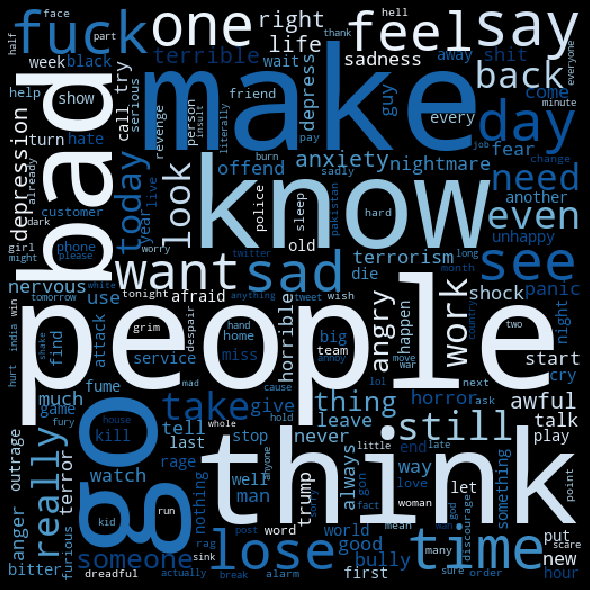

In [42]:
depressive_words = ' '.join(list(train[train['label'] == 1]['message_processed']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### How many depressive words

In [43]:
len(depressive_words.split())

31005

<Figure size 720x576 with 0 Axes>

((-0.5, 511.5, 511.5, -0.5),)

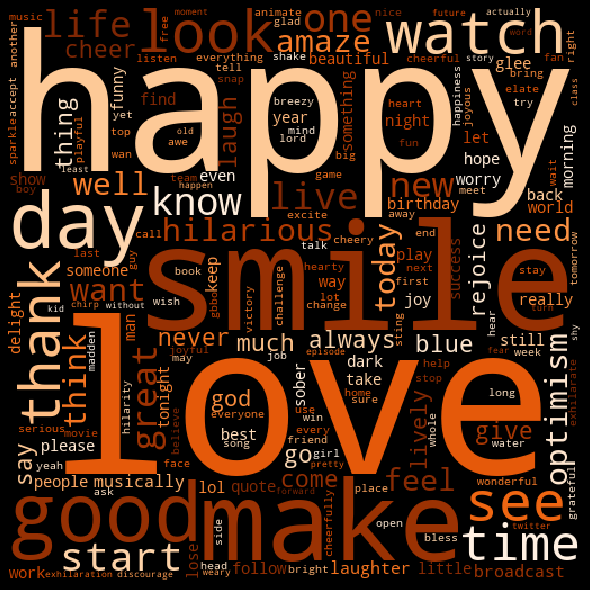

In [44]:
positive_words = ' '.join(list(train[train['label'] == 0]['message_processed']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Oranges").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

### How many positive words

In [45]:
l=positive_words.split()
len(l)

20436

# Predictions with TF-IDF

### Feature engineering- CountVectorizer, tf-idf transformer. Lastly, train several classifiers.
Compared performance with many metrics: accuracy (not good for unbalanced classes), F1 score, average_precision_score, roc_auc_score, cohen_kappa_score, confusion_matrix and classification_report 

In [46]:
X_train = train.message_processed
X_test = test.message_processed
y_train = train.label
y_test = test.label

In [47]:
train.label.shape

(6321,)

In [48]:
X_test.head()

0    academy science eschew normally sober tone sci...
1                                 blew opportunity mad
2    deppression real partner depress people truly ...
3    interesting choice word confirm government fun...
4                                             cnn sure
Name: message_processed, dtype: object

### Naive Bayes classifier for multinomial models
Naive Bayes classifier can provides a nice baseline for this task. The multinomial variant most suitable for text data.


In [49]:
y_test.value_counts()

1    1473
0    1272
Name: label, dtype: int64

In [50]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [82]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap="Blues",annot=False):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.0)
    sns.heatmap(cm, cmap=cmap,fmt='g', annot=annot,annot_kws={"size": 16})# font size
    plt.title(title)
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks+0.5, target_names, rotation=45,ha='center')
    plt.yticks(tick_marks+0.5, target_names,rotation=0,va='bottom')
    ax = plt.gca() 
    ax.set_ylim(len(my_tags), 0)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy 0.8123861566484517
F1 0.8477682530298551
cohen_kappa_score 0.6136945873383477
              precision    recall  f1-score   support

  pos tweets       0.95      0.63      0.76      1272
  neg tweets       0.75      0.97      0.85      1473

    accuracy                           0.81      2745
   macro avg       0.85      0.80      0.80      2745
weighted avg       0.84      0.81      0.81      2745



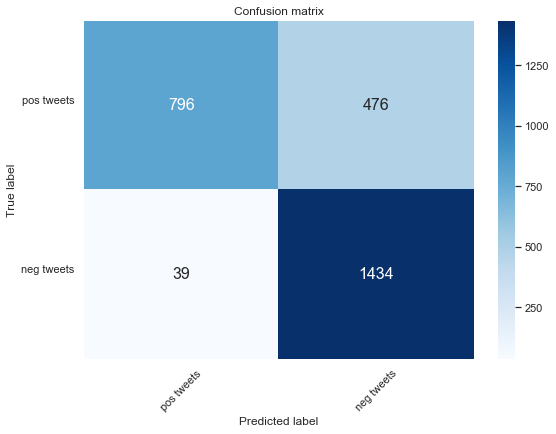

In [83]:
y_pred = nb.predict(X_test)
my_tags=['pos tweets','neg tweets']
print('accuracy %s' % accuracy_score( y_test,y_pred))
print('F1 %s' % f1_score( y_test,y_pred))
print('cohen_kappa_score %s' % cohen_kappa_score( y_test,y_pred))
print(classification_report(y_test, y_pred,target_names=my_tags))
cm=confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm,annot=True)


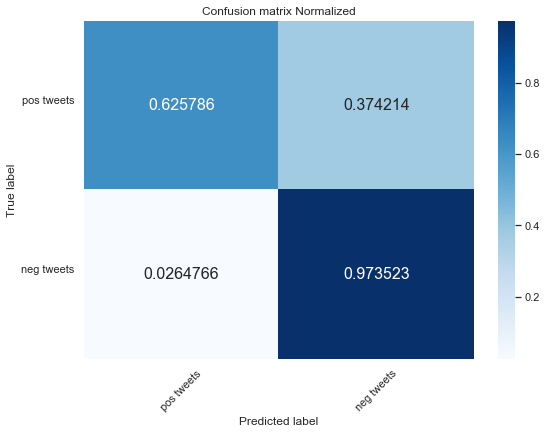

In [84]:
plot_confusion_matrix(cm_normalized, 'Confusion matrix Normalized',annot=True)

In [85]:
y_pred = nb.predict_proba(X_test)
print('average_precision_score %s' % average_precision_score( y_test,y_pred[:,1])) # pass probability for the positive
print('roc_auc_score %s' % roc_auc_score( y_test,y_pred[:,1]))

average_precision_score 0.9243242710816247
roc_auc_score 0.9214487611386508


### Kappa, average_precision_score are good with imbalanced dataset. accuracy_score is not good with imbalanced dataset

### LinearSVC
Linear Support Vector Machine is widely regarded as one of the best text classification algorithms.

In [86]:
lsvc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC())
               ])
lsvc.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                     

accuracy 0.8400728597449909
F1 0.8552588196505111
cohen_kappa_score 0.6769137962236834
              precision    recall  f1-score   support

  pos tweets       0.85      0.79      0.82      1272
  neg tweets       0.83      0.88      0.86      1473

    accuracy                           0.84      2745
   macro avg       0.84      0.84      0.84      2745
weighted avg       0.84      0.84      0.84      2745

average_precision_score 0.7961865705438542
roc_auc_score 0.8368774737732007


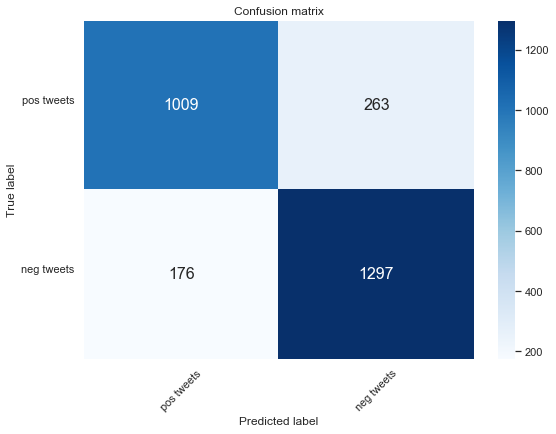

In [87]:
y_pred = lsvc.predict(X_test)
my_tags=['pos tweets','neg tweets']
print('accuracy %s' % accuracy_score( y_test,y_pred))
print('F1 %s' % f1_score( y_test,y_pred))
print('cohen_kappa_score %s' % cohen_kappa_score( y_test,y_pred))
print(classification_report(y_test, y_pred,target_names=my_tags))
cm=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,annot=True)
print('average_precision_score %s' % average_precision_score( y_test,y_pred))
print('roc_auc_score %s' % roc_auc_score( y_test,y_pred))

### Linear support vector machine with SGD training

In [88]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

accuracy 0.7504553734061931
F1 0.8079618727221757
cohen_kappa_score 0.4809303874046892
[[ 619  653]
 [  32 1441]]
average_precision_score 0.6848644263928867
roc_auc_score 0.7324554240479576


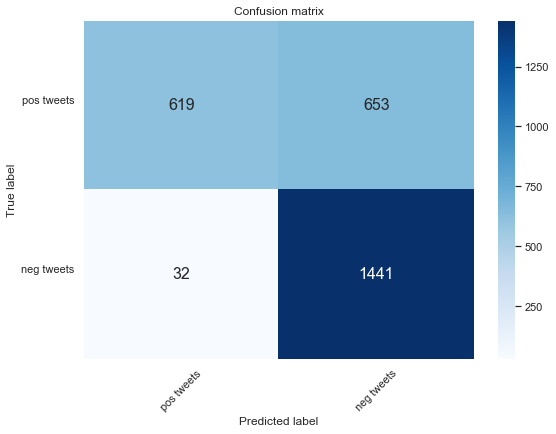

In [89]:
y_pred = sgd.predict(X_test)
my_tags=['pos tweets','neg tweets']
print('accuracy %s' % accuracy_score( y_test,y_pred))
print('F1 %s' % f1_score( y_test,y_pred))
print('cohen_kappa_score %s' % cohen_kappa_score( y_test,y_pred))
cm=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,annot=True)
print(confusion_matrix(y_test, y_pred))
print('average_precision_score %s' % average_precision_score( y_test,y_pred))
print('roc_auc_score %s' % roc_auc_score( y_test,y_pred))

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                      

accuracy 0.7344262295081967
F1 0.7985631389886708
cohen_kappa_score 0.4459902011024798
[[ 571  701]
 [  28 1445]]


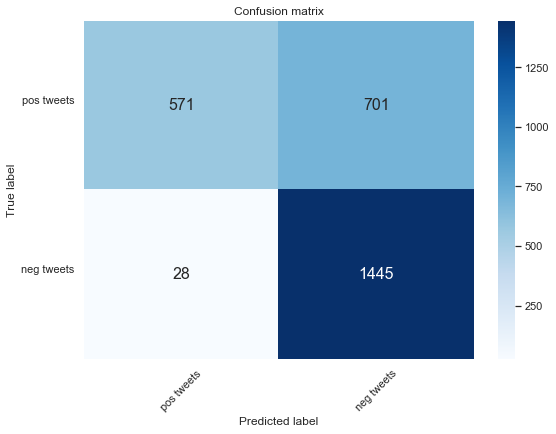

In [93]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ]) # use loss='log' for predict_proba
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test) 
 
my_tags=['pos tweets','neg tweets']
print('accuracy %s' % accuracy_score( y_test,y_pred))
print('F1 %s' % f1_score( y_test,y_pred))
print('cohen_kappa_score %s' % cohen_kappa_score( y_test,y_pred))
cm=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,annot=True)
print(confusion_matrix(y_test, y_pred))


In [94]:
y_pred = sgd.predict_proba(X_test)
print('average_precision_score %s' % average_precision_score( y_test,y_pred[:,1]))
print('roc_auc_score %s' % roc_auc_score( y_test,y_pred[:,1]))

average_precision_score 0.9164990331590137
roc_auc_score 0.9091556827934263


### Logistic regression

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
  

accuracy 0.8360655737704918
F1 0.8599003735990037
cohen_kappa_score 0.6655924475465409
              precision    recall  f1-score   support

   pos tweet       0.91      0.72      0.80      1272
   neg tweet       0.79      0.94      0.86      1473

    accuracy                           0.84      2745
   macro avg       0.85      0.83      0.83      2745
weighted avg       0.85      0.84      0.83      2745



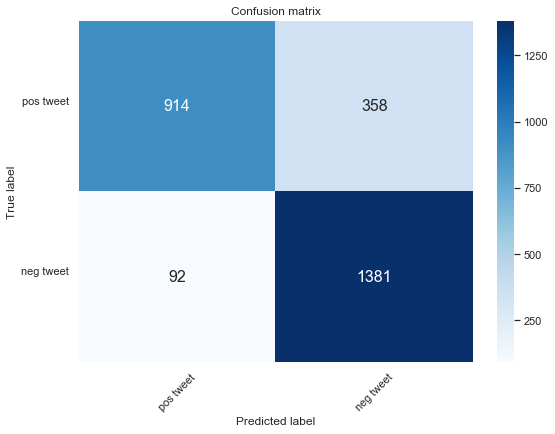

In [95]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression()),
               ])
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
my_tags=['pos tweet','neg tweet']
cm=confusion_matrix(y_test, y_pred)
print('accuracy %s' % accuracy_score(y_test,y_pred))
print('F1 %s' % f1_score( y_test,y_pred))
print('cohen_kappa_score %s' % cohen_kappa_score( y_test,y_pred))
print(classification_report(y_test, y_pred,target_names=my_tags))
plot_confusion_matrix(cm,annot=True)

In [96]:
y_pred = logreg.predict_proba(X_test)

In [97]:
print('average_precision_score %s' % average_precision_score( y_test,y_pred[:,1])) # pass probability for the positive 
print('roc_auc_score %s' % roc_auc_score( y_test,y_pred[:,1]))

average_precision_score 0.9252249529144627
roc_auc_score 0.9200221385355688


### Amoung the four models, MultinomialNB is best because of high recall for negative tweet, and not too bad precision for negative tweet. Our focus is negative tweet and we want to minimize False Negative Rate

### Check MultinomialNB scores using Cross validation, results are consistent with ones without Cross validation

In [98]:
X= pd.concat([X_train, X_test])
y= pd.concat([y_train, y_test])

In [99]:
print('Cross_val accuracy %s' % cross_val_score(nb, X, y, cv=6,scoring='accuracy'))

Cross_val accuracy [0.81746032 0.82671958 0.81998676 0.82792852 0.84503311 0.85033113]


In [100]:
print('Cross_val average_precision %s' % cross_val_score(nb, X, y, cv=6,scoring='average_precision'))

Cross_val average_precision [0.93536216 0.93700368 0.93150537 0.9454905  0.93863412 0.94441156]


In [101]:
print('Cross_val roc_auc %s' % cross_val_score(nb, X, y, cv=6,scoring='roc_auc'))

Cross_val roc_auc [0.91641628 0.91887439 0.91441592 0.93246593 0.92467942 0.93310056]


In [102]:
print('Cross_val f1 %s' % cross_val_score(nb, X, y, cv=6,scoring='f1'))

Cross_val f1 [0.85903984 0.86536485 0.8609407  0.86748216 0.87761506 0.88265836]


In [103]:
print('Cross_val f1_micro %s' % cross_val_score(nb, X, y, cv=6,scoring='f1_micro'))

Cross_val f1_micro [0.81746032 0.82671958 0.81998676 0.82792852 0.84503311 0.85033113]


In [104]:
print('Cross_val f1_macro %s' % cross_val_score(nb, X, y, cv=6,scoring='f1_macro'))

Cross_val f1_macro [0.80006401 0.81116109 0.80289061 0.81109957 0.83321186 0.8380385 ]


### Also tried ngram=2, MultinomialNB still is the best, but a little worst than ngram=1

## Use MultinomialNB model to predict tweets

In [105]:
pm = process_message('Loving how me and my lovely partner is talking about what we want.')
nb.predict(pm)


array([0, 0, 0, 1, 1], dtype=int64)

In [67]:
pm = process_message('Very rewarding when a patient hugs you and tells you they feel great after changing the diet and daily habits')
nb.predict(pm)


array([1, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int64)

In [106]:
pm = process_message('Hi hello depression and anxiety are the worst')
nb.predict(pm)

array([0, 1, 1, 1], dtype=int64)

In [107]:
pm = process_message('My depression will not let me work out')
nb.predict(pm)

array([1, 1, 1], dtype=int64)

In [108]:
pm = process_message('how to deal with anxiety? I am in tear')
nb.predict(pm)

array([1, 1, 1], dtype=int64)

### Using TextBlob to calculate sentiment polarity in the range of [-1,1] 
### 1 = positive sentiment and -1 =negative sentiment

In [109]:
train['TextBlobpolarity'] = train['message_processed'].apply(lambda text: TextBlob(text).sentiment.polarity)

In [110]:
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = train.loc[train.TextBlobpolarity == 1, ['message_processed']].sample(5).values
i=0
for c in cl:
    i=i+1
    print(i,'.',c[0])

5 random reviews with the highest positive sentiment polarity: 

1 . look forward detour bring delightful surprise lifequote
2 . finn sing fight feel shower spy one best scene show glee
3 . groovy restaurant get cheeseburger fry discriminate rating yummy delicious politicallycorrect
4 . pat awesome belichick awesome
5 . blake lively flawless


In [113]:
print('5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = train.loc[train.TextBlobpolarity == 0, ['message_processed']].sample(5).values
i=0
for c in cl:
    i=i+1
    print(i,'.',c[0])

5 random reviews with the most neutral sentiment(zero) polarity: 

1 . time remove team somehow screw rip band aid sting bit everyone get
2 . symmetry key everything must aesthetically please possible hold twin pistol deaththekid bot
3 . return matt damon director paul greengrass bring back exhilarate rather face entertainment movie
4 . help maintain boost status world class centre education culture tolerance outrage
5 . get comedic relief season premiere modernfamily girl need


In [114]:
print('5 reviews with the most negative polarity: \n')
cl = train.loc[train.TextBlobpolarity == -1, ['message_processed']].sample(5).values
i=0
for c in cl:
    i=i+1
    print(i,'.',c[0])

5 reviews with the most negative polarity: 

1 . rooney dear dear fucking dreadful
2 . shew awful
3 . control avoidmmt guy terrible
4 . penny dreadful temporada
5 . opinion sport dreadful


## Visualization with Plotly
### Distribution of sentiment polarity score by label

### Overall sentiment polarity is more consistent with the positive tweets than negative ones. Positive tweets and negative tweets have nice seperation except polarity=0. Will look into it later


In [115]:
def plot_polarity_score (df,column, label):   
    x1 = df.loc[df['label'] == 1, column]
    x0 = df.loc[df['label'] == 0, column]

    trace1 = go.Histogram(
        x=x0, name='Positive',
        opacity=0.75
    )
    trace2 = go.Histogram(
        x=x1, name = 'Negative',
        opacity=0.75
    )

    data = [trace1, trace2]
    layout = go.Layout(barmode='stack', title='Distribution of '+ label +' of tweet grouped by label'
                      ,
                      xaxis=dict(
                                title=label,
                                titlefont=dict(
                                family='Arial, sans-serif',
                                size=18,
                                color='lightgrey'))
                       ,
                      yaxis=dict(
                                title='Density',
                                titlefont=dict(
                                family='Arial, sans-serif',
                                size=18,
                                color='lightgrey'))
            )
    fig = go.Figure(data=data, layout=layout)

    iplot(fig, filename= label + 'stack histogram')

In [117]:
# a big spike around 0: neutral or mixed tweets
plot_polarity_score (train,'TextBlobpolarity','TextBlob Polarity')

## What is the percentage of Negative tweets gets polarity of >=0

In [116]:
train[(train['label']==1) & (train['TextBlobpolarity']>=0)].shape[0] / train[(train['label']==1) ].shape[0] *100

55.884686590848986

### Rule-based lexicon analysis using Bin Liu's opinion lexicon
opinion lexicon downloaded from http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar

In [118]:
positive = pd.read_csv('positive-words.txt', sep="\n", header=28, encoding='ISO-8859-1')
negative = pd.read_csv('negative-words.txt', sep="\n", header=29, encoding='ISO-8859-1')

In [119]:
poslist=list(positive.iloc[:,0])
poslist[:7]

['a+',
 'abound',
 'abounds',
 'abundance',
 'abundant',
 'accessable',
 'accessible']

In [120]:
neglist=list(negative.iloc[:,0])
neglist[:7]

['2-faced',
 '2-faces',
 'abnormal',
 'abolish',
 'abominable',
 'abominably',
 'abominate']

In [121]:
def calculate_polarity(message):
    wordlist=message.split()
    p=0
    n=0
    for word in wordlist:
        if word in poslist:
            p+=1
        if word in neglist:
            n+=1
    return p-n 

In [122]:
train['lexiconpolarity'] = train['message_processed'].apply(lambda text: calculate_polarity(text))

In [123]:
train.head()

,Unnamed: 0,ID,Tweet,anger,disgust,fear,joy,love,optimism,pessimism,sadness,trust,neg,pos,label,message_processed,message_length,TextBlobpolarity,lexiconpolarity
0,0,2017-En-21441,Ã¢ÂÂWorry is a down payment on a problem you...,0,0,0,0,0,1,0,0,1,0,2,0,worry payment problem may never joyce meyer mo...,107,0.00,-3
1,1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,1,1,1,0,0,0,0,3,0,whatever decide make sure make happy,56,0.65,1
2,3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,1,0,1,0,0,0,0,2,0,accept challenge literally even feel exhilarat...,112,0.00,2
3,4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,1,0,0,0,0,0,0,0,2,0,1,roommate okay spell autocorrect terrible first...,98,-0.25,-1
4,5,2017-En-22190,No but that's so cute. Atsu was probably shy a...,0,0,0,1,0,0,0,0,0,0,1,0,cute atsu probably shy photo cherry help uwu,94,0.00,1


In [124]:
plot_polarity_score (train,'lexiconpolarity','Lexicon Polarity')

## What is the percentage of Negative tweets gets polarity of >=0

In [125]:
train[(train['label']==1) & (train['lexiconpolarity']>=0)].shape[0] / train[(train['label']==1) ].shape[0] *100

26.633165829145728

#### Investigated on the tweets labeled with 0 (positive) with manual polarity =0. It's one-third of the data 

In [126]:
train[(train['label'] == 0) & (train['lexiconpolarity']== 0)  ].shape

(683, 19)

In [127]:
print('10 random 0-labeled reviews with the lexiconpolarity ==0: \n')
cl = train.loc[(train.lexiconpolarity == 0) & (train['label'] == 0), ['Tweet','label']].sample(10).values
i=0
for c in cl:
    i=i+1
    print(i,'.',c[0],'---',c[1])

10 random 0-labeled reviews with the lexiconpolarity ==0: 

1 . HMS Pinafore' time.\n\nI need some mirth. --- 0
2 . Starting at 22 minutes, this week's @bestshow4life is straight-up paradigm shift level mirth. --- 0
3 . Being in the countryside all day was so pleasing --- 0
4 . @danmericaCNN @aefadul22 HRC has the experience, temperment, knowledge &amp; ability to lead us in this perilous time --- 0
5 . Ã¢ÂÂªOLD FISH  --- 0
6 . Trying to think positive, and not let this situation discourage me Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨Ã¢ÂÂ¨ --- 0
7 . @sportinglifecan I keep a down vest or sweater in m

### Investigated on the tweets labeled with 1 (negative) with manualpolarity =0. 

In [128]:
print('10 random 1-labeled reviews with the lexiconpolarity ==0: \n')
cl = train.loc[(train.lexiconpolarity == 0) & (train['label'] == 1), ['Tweet','label']].sample(10).values
i=0
for c in cl:
    i=i+1
    print(i,'.',c[0],'---',c[1])

10 random 1-labeled reviews with the lexiconpolarity ==0: 

1 . @CNN Wait, didn't she get a case of the ass when Donald Trump called it terrorism BEFORE all the facts were in?  I guess it's ok if she does --- 1
2 . Just joined #pottermore and was sorted into HUFFLEPUFF Ã°ÂÂÂ¡Ã°ÂÂÂ¡Ã°ÂÂÂ¡  --- 1
3 . #tulsa - Police manufacture murder... Wonder why we carry burners...? - MaxLevelz  --- 1
4 . Good luck to all Fury-Haney players playing this weekend at the Future Stars showcase in Frisco, Tx.  #KGB #G-town #fury --- 1
5 . When you wake up, scroll through social media, and another father was taken from his child  #everyday #KeithLamontScott --- 1
6 . If her legs aren't shaking, you're not doing it right. --- 1
7 . @Eeevah14 don't I know it, try not to fret my sweet little pupper --- 1
8 . @KhoroshiySoldat --prepared.\n\n'Not as far as I know.' was her dull reply. 'There are still survivors, members from it. Like I said,-/ --- 1
9 . And they cover these police shootings fairly well the

### Many are due to mix of good words and bad words. Since our goal is to detect negative mode, let's try using negative score only

In [129]:
def calculate_negativity(message):
    wordlist=message.split()
    n=0
    for word in wordlist:
        if word in neglist:
            n+=1
    return n 

In [130]:
train['lexiconnegativity'] = train['message_processed'].apply(lambda text: calculate_negativity(text))

In [131]:
plot_polarity_score (train,'lexiconnegativity','Lexicon Negativity')

In [132]:
#### Investigated on the tweets labeled with 1 (negative) with negativity=0. 
train[(train['label'] == 0) & (train['lexiconnegativity']== 1)  ].shape

(724, 20)

In [133]:
print('10 random 0-labeled reviews with the negativity =1: \n')
cl = train.loc[(train['label'] == 0) & (train['lexiconnegativity']== 1) , ['Tweet','label']].sample(10).values
i=0
for c in cl:
    i=i+1
    print(i,'.',c[0],'---',c[1])

10 random 0-labeled reviews with the negativity =1: 

1 . Fear blocks blessings, faith unlocks them. #ManUp  #faith --- 0
2 . @PhilGlutting Hey There Phil Glutting thank you for following us, it's appreciated :) #smile --- 0
3 . If I do my homework now I can watch revenge and possibly go out tonight'\n*plays on phone for 2 hours to avoid doing homework --- 0
4 . GAMEDAY VS BUFORD TODAY AT 5:30 AT HOME!!!!!!!!! NEVER BEEN SO EXCITED #revenge --- 0
5 . Season 3 of penny dreadful is on Netflix...well my afternoon is filled --- 0
6 . TONIGHT - Fulford Arms, York \nTOMORROW - Bank Top Tavern, Oldham\nNEXT SATURDAY- Big Hands, Manchester \n\n#livemusic #punk #blues #rockandroll --- 0
7 . @AdamAaronovich Well, there's no need to sulk. You can always request a song, you know. --- 0
8 . Why can't you just be mine. #forlorn --- 0
9 . Transitioning to a new job is hard when you have nothing but joyful memories of the previous one. Thanks @LifeTeen for changing my life! Ã¢ÂÂ¤Ã¯Â¸Â --- 0
10 . A g

### Most of these tweets do have negative words. Tweets with mixed polarities words can be hard to tag. Domain specific opinion lexicon is critical to our mood detection

### Let's try senti function from Pattern package to evaluate sentiment

In [134]:
train['patternpolarity'] = train['message_processed'].apply(lambda text: senti(text)[0])
train.head()

,Unnamed: 0,ID,Tweet,anger,disgust,fear,joy,love,optimism,pessimism,...,trust,neg,pos,label,message_processed,message_length,TextBlobpolarity,lexiconpolarity,lexiconnegativity,patternpolarity
0,0,2017-En-21441,Ã¢ÂÂWorry is a down payment on a problem you...,0,0,0,0,0,1,0,...,1,0,2,0,worry payment problem may never joyce meyer mo...,107,0.00,-3,3,0.00
1,1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,1,1,1,0,...,0,0,3,0,whatever decide make sure make happy,56,0.65,1,0,0.65
2,3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,1,0,1,0,...,0,0,2,0,accept challenge literally even feel exhilarat...,112,0.00,2,0,0.00
3,4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,1,0,0,0,0,0,...,0,2,0,1,roommate okay spell autocorrect terrible first...,98,-0.25,-1,1,-0.25
4,5,2017-En-22190,No but that's so cute. Atsu was probably shy a...,0,0,0,1,0,0,0,...,0,0,1,0,cute atsu probably shy photo cherry help uwu,94,0.00,1,0,0.00


### Distribution of sentiment polarity score by label
### Pattern sentiment gave very similar plot to TextBlob polarity plot

In [135]:
plot_polarity_score (train,'patternpolarity','Pattern Polarity')

## What is the percentage of Negative tweets gets polarity of >=0

In [136]:
train[(train['label']==1) & (train['patternpolarity']>=0)].shape[0] / train[(train['label']==1) ].shape[0]

0.5588468659084899

### Pattern polarity and TextBlobpolarity gave similar results. Opinion lexicon had better results

### Lexicon analysis with SentiWords
### SentiWords is a high coverage resource containing roughly 155,000 English words associated with a sentiment score included between -1 and 1. It contains mostly unigram and bigram 

In [137]:
file = open("SentiWords_1.1.txt", "r") 
i=0
lemma=[]
pos=[]
prior_polarity_score=[]

for line in file: 
    i+=1
    if (i >=27): #word list starts at row 27
        name, score=line.split()
        le, p=name.split('#')
        lemma.append(le)
        pos.append(p)
        prior_polarity_score.append(score)
SentiWords=pd.DataFrame({'lemma':lemma, 'pos':pos, 'prior_polarity_score':prior_polarity_score} )
SentiWords.to_csv(r'SentiWords.csv', index=False)

In [138]:
SentiWords = pd.read_csv(r'SentiWords.csv')

In [140]:
SentiWords.tail()

,lemma,pos,prior_polarity_score
155282,zymolytic,a,-0.19821
155283,zymosis,n,0.15754
155284,zymotic,a,-0.08847
155285,zymurgy,n,0.00000
155286,zyrian,n,0.00000


In [100]:
### convert to dictionary

In [144]:
dictSentiWords =dict(zip(SentiWords.lemma,zip(SentiWords.pos,SentiWords.prior_polarity_score)))

In [145]:
dictSentiWords.get('zymotic',(0,0))[1]

-0.08847000000000001

In [146]:
def calculate_polarity_SentiWords(message):
    wordlist=message.split()
    s=0
    polarity=0
    for word in wordlist:
        s=float(dictSentiWords.get(word,(0,0))[1])
        polarity+=s
    
    return polarity

In [147]:
train['SentiWords_polarity'] = train['message_processed'].apply(lambda text: calculate_polarity_SentiWords(text))


In [148]:
plot_polarity_score (train,'SentiWords_polarity','SentiWords Polarity')

### the blue pike is a lot smaller compared with provious 3 plots. It could be the result of bigger coverage of lexicon collection. Also the seperate of positive vs negative is not bad

## What is the percentage of Negative tweets gets polarity of >=0

In [149]:
train[(train['label']==1) & (train['SentiWords_polarity']>=0)].shape[0] / train[(train['label']==1) ].shape[0]

0.4837344617825972

### Lexicon analysis with NRC-Emotion-Lexicon
### These lexicons are created by manual annotation. 14,182 unigrams (words). sentiments:negative, positive; emotions: anger, anticipation, disgust, fear, joy, sadness, surprise, trust http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

In [173]:
NRC = pd.read_csv('./data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', sep="\t", encoding='ISO-8859-1',header=None,names=['word','emotion','score'])
NRC.head()

,word,emotion,score
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0


### Will only use sentiments:negative, positive from the list

In [174]:
n=NRC[NRC.emotion=='negative']
n.tail()

,word,emotion,score
141775,zone,negative,0
141785,zoo,negative,0
141795,zoological,negative,0
141805,zoology,negative,0
141815,zoom,negative,0


In [175]:
p=NRC[NRC.emotion=='positive']
p.head()

,word,emotion,score
6,aback,positive,0
16,abacus,positive,0
26,abandon,positive,0
36,abandoned,positive,0
46,abandonment,positive,0


In [176]:
NRC=pd.merge(p, n, on='word')
NRC.head()

,word,emotion_x,score_x,emotion_y,score_y
0,aback,positive,0,negative,0
1,abacus,positive,0,negative,0
2,abandon,positive,0,negative,1
3,abandoned,positive,0,negative,1
4,abandonment,positive,0,negative,1


In [177]:
NRC['ps']=NRC['score_x']+ NRC['score_y']

In [178]:
NRC.shape

(14182, 6)

### are there any records that are both negative and positive?

In [179]:
NRC[NRC['ps']==2].shape

(81, 6)

In [180]:
NRC[NRC['ps']==2].head(10)

,word,emotion_x,score_x,emotion_y,score_y,ps
61,abundance,positive,1,negative,1,2
718,armed,positive,1,negative,1,2
1018,balm,positive,1,negative,1,2
1366,boast,positive,1,negative,1,2
1382,boisterous,positive,1,negative,1,2
1419,bookworm,positive,1,negative,1,2
1579,buck,positive,1,negative,1,2
1916,celebrity,positive,1,negative,1,2
2004,charmed,positive,1,negative,1,2
2130,circumvention,positive,1,negative,1,2


### since it's a very small percentage, it's easier just to drop them

In [116]:
### drop neutral or mixed senti too

In [169]:
NRC[NRC['ps']==0].shape

(8627, 8)

In [170]:
NRC[NRC['ps']==0].tail(10)

,word,emotion_x,score_x,posneg_x,emotion_y,score_y,posneg_y,ps
14170,zebra,positive,0,NaN,negative,0,NaN,0
14171,zenith,positive,0,NaN,negative,0,NaN,0
14172,zephyr,positive,0,NaN,negative,0,NaN,0
14173,zeppelin,positive,0,NaN,negative,0,NaN,0
14176,zodiac,positive,0,NaN,negative,0,NaN,0
14177,zone,positive,0,NaN,negative,0,NaN,0
14178,zoo,positive,0,NaN,negative,0,NaN,0
14179,zoological,positive,0,NaN,negative,0,NaN,0
14180,zoology,positive,0,NaN,negative,0,NaN,0
14181,zoom,positive,0,NaN,negative,0,NaN,0


In [181]:
NRC.drop(NRC[(NRC['ps']==2)|(NRC['ps']==0)].index, inplace=True)
NRC.shape

(5474, 6)

In [182]:
NRC.head()

,word,emotion_x,score_x,emotion_y,score_y,ps
2,abandon,positive,0,negative,1,1
3,abandoned,positive,0,negative,1,1
4,abandonment,positive,0,negative,1,1
7,abba,positive,1,negative,0,1
13,abduction,positive,0,negative,1,1


In [183]:
NRC[NRC['ps']==2].shape

(0, 6)

In [184]:
### label=1 for neg tweet
NRC['score']=NRC['ps'].apply(lambda a:-1 if a==1 else 1 )
NRC.head()

,word,emotion_x,score_x,emotion_y,score_y,ps,score
2,abandon,positive,0,negative,1,1,-1
3,abandoned,positive,0,negative,1,1,-1
4,abandonment,positive,0,negative,1,1,-1
7,abba,positive,1,negative,0,1,-1
13,abduction,positive,0,negative,1,1,-1


### convert to dictionary

In [187]:
dictNRC =dict(zip(NRC.word,NRC.score))

In [185]:
def calculate_polarity_NRC(message):
    wordlist=message.split()
    s=0
    polarity=0
    for word in wordlist:
        s=float(dictNRC.get(word,0))
        polarity+=s
    
    return polarity

In [188]:
train['NRC_polarity'] = train['message_processed'].apply(lambda text: calculate_polarity_NRC(text))

In [189]:
plot_polarity_score (train,'NRC_polarity','NRC Polarity')

## What is the percentage of Negative tweets gets polarity of >=0

In [190]:
train[(train['label']==1) & (train['NRC_polarity']>=0)].shape[0] / train[(train['label']==1) ].shape[0]


0.08754297804813542

### Since Bin Liu's Opinion and NRC-Emotion-Lexicon gave lower error rate on detecting negative mood, will include both columns in train set  and test set after converting them to binary 

In [191]:
train['lexiconpolarity']=train['lexiconpolarity'].apply(lambda a:1 if a<0 else 0)

In [192]:
train['NRC_polarity']=train['NRC_polarity'].apply(lambda a:1 if a<0 else 0)

In [193]:
X_train =pd.concat([X_train, train[['lexiconpolarity','NRC_polarity']]], axis=1)

X_train.shape

(6321, 3)

In [194]:
test['lexiconpolarity'] = test['message_processed'].apply(lambda text: calculate_polarity(text))

In [195]:
train['message_processed'].head()

0    worry payment problem may never joyce meyer mo...
1                 whatever decide make sure make happy
2    accept challenge literally even feel exhilarat...
3    roommate okay spell autocorrect terrible first...
4         cute atsu probably shy photo cherry help uwu
Name: message_processed, dtype: object

In [196]:
test['NRC_polarity'] = test['message_processed'].apply(lambda text: calculate_polarity_NRC(text))

In [197]:
test['lexiconpolarity']=test['lexiconpolarity'].apply(lambda a:1 if a<0 else 0)

In [198]:
test['NRC_polarity']=test['NRC_polarity'].apply(lambda a:1 if a<0 else 0)

In [199]:
X_test =pd.concat([X_test, test[['lexiconpolarity','NRC_polarity']]], axis=1)
X_test.shape

(2745, 3)

In [200]:
numeric_features = 'message_processed'

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), 'message_processed')], remainder='passthrough')
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultinomialNB())])

In [201]:
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                   

In [140]:
y_pred = model.predict(X_test)

In [141]:
my_tags=['pos tweets','neg tweets']
print('accuracy %s' % accuracy_score( y_test,y_pred))
print('F1 %s' % f1_score( y_test,y_pred))
print('cohen_kappa_score %s' % cohen_kappa_score( y_test,y_pred))
print(classification_report(y_test, y_pred,target_names=my_tags))
print(confusion_matrix(y_test, y_pred))

accuracy 0.8342440801457195
F1 0.8620794180054562
cohen_kappa_score 0.6602684884691621
              precision    recall  f1-score   support

  pos tweets       0.94      0.68      0.79      1272
  neg tweets       0.78      0.97      0.86      1473

    accuracy                           0.83      2745
   macro avg       0.86      0.82      0.83      2745
weighted avg       0.86      0.83      0.83      2745

[[ 868  404]
 [  51 1422]]


In [202]:
y_pred = model.predict_proba(X_test)
print('average_precision_score %s' % average_precision_score( y_test,y_pred[:,1])) # pass probability for the positive
print('roc_auc_score %s' % roc_auc_score( y_test,y_pred[:,1]))

average_precision_score 0.9275218523211493
roc_auc_score 0.9265641611907416


### After including 'lexiconpolarity','NRC_polarity', the scores are higher overall

### Include bi-gram: ngram_range=(1, 2). 

In [214]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2)), 'message_processed')], remainder='passthrough')
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultinomialNB())])

In [215]:
model.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                   

In [216]:
y_pred = model.predict(X_test)

In [217]:
my_tags=['pos tweets','neg tweets']
print('accuracy %s' % accuracy_score( y_test,y_pred))
print('F1 %s' % f1_score( y_test,y_pred))
print('cohen_kappa_score %s' % cohen_kappa_score( y_test,y_pred))
print(classification_report(y_test, y_pred,target_names=my_tags))
print(confusion_matrix(y_test, y_pred))

accuracy 0.7296903460837887
F1 0.7974890829694323
cohen_kappa_score 0.43469514520423846
              precision    recall  f1-score   support

  pos tweets       0.98      0.43      0.59      1272
  neg tweets       0.67      0.99      0.80      1473

    accuracy                           0.73      2745
   macro avg       0.82      0.71      0.70      2745
weighted avg       0.81      0.73      0.70      2745

[[ 542  730]
 [  12 1461]]


In [218]:
y_pred = model.predict_proba(X_test)
print('average_precision_score %s' % average_precision_score( y_test,y_pred[:,1])) # pass probability for the positive
print('roc_auc_score %s' % roc_auc_score( y_test,y_pred[:,1]))

average_precision_score 0.9247562268982419
roc_auc_score 0.9217996793434868


### Most scores decreased. So we don't use bi-gram

### GridSearch to tune hypterparameters

In [220]:
numeric_features = 'message_processed'

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), 'message_processed')], remainder='passthrough')
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultinomialNB())])

In [221]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'classifier__alpha': [0.1, 0.3, 0.5, 0.8],
    'classifier__fit_prior': [True,False],
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5)
search.fit(X_train,y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

y_pred = search.predict(X_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='passthrough',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('tfidf',
                                                                         TfidfVectorizer(analyzer='word',
                                                                                         binary=False,
                                                                                         decode_error='strict',
                                                                                         dtype=<class 'numpy.float64'>,
      

Best parameter (CV score=0.849):
{'classifier__alpha': 0.5, 'classifier__fit_prior': False}


In [222]:
my_tags=['pos tweets','neg tweets']
print('accuracy %s' % accuracy_score( y_test,y_pred))
print('F1 %s' % f1_score( y_test,y_pred))
print('cohen_kappa_score %s' % cohen_kappa_score( y_test,y_pred))
print(classification_report(y_test, y_pred,target_names=my_tags))
print(confusion_matrix(y_test, y_pred))

accuracy 0.8520947176684882
F1 0.8690322580645161
cohen_kappa_score 0.7001176958732178
              precision    recall  f1-score   support

  pos tweets       0.89      0.78      0.83      1272
  neg tweets       0.83      0.91      0.87      1473

    accuracy                           0.85      2745
   macro avg       0.86      0.85      0.85      2745
weighted avg       0.86      0.85      0.85      2745

[[ 992  280]
 [ 126 1347]]


In [223]:
y_pred = search.predict_proba(X_test)
print('average_precision_score %s' % average_precision_score( y_test,y_pred[:,1])) # pass probability for the positive
print('roc_auc_score %s' % roc_auc_score( y_test,y_pred[:,1]))

average_precision_score 0.9284963547554057
roc_auc_score 0.9273273749290157


### Ensemble learning
Max voting with SGDClassifier, MultinomialNB, LogisticRegression

In [203]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(ngram_range=(1,1)), 'message_processed')], remainder='passthrough')
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearSVC())])
model.fit(X_train,y_train)
y_pred2 = model.predict(X_test)
 

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                   

In [204]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(ngram_range=(1,1)), 'message_processed')], remainder='passthrough')
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))])
model.fit(X_train,y_train)
y_pred3 = model.predict(X_test)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                   

In [205]:
y_pred[:10]

array([[0.22966252, 0.77033748],
       [0.09098425, 0.90901575],
       [0.02464113, 0.97535887],
       [0.15975749, 0.84024251],
       [0.27795013, 0.72204987],
       [0.1990079 , 0.8009921 ],
       [0.68597558, 0.31402442],
       [0.06441973, 0.93558027],
       [0.46937499, 0.53062501],
       [0.71281042, 0.28718958]])

In [206]:
y_pred1=[1 if y_pred[i,1]>0.5 else 0 for  i in range(len(y_pred))]
y_pred1[:10]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0]

In [207]:
y_pred2[:10]

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 0], dtype=int64)

In [208]:
y_pred3[:10]

array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0], dtype=int64)

In [209]:
y_pred_sum=y_pred1+y_pred2+y_pred3
y_pred_sum[:10]

array([3, 3, 3, 2, 2, 3, 0, 3, 1, 0], dtype=int64)

In [210]:
y_pred_ens=[1 if y_pred_sum[i]>1 else 0 for  i in range(len(y_pred_sum))]
y_pred_ens[:10]

[1, 1, 1, 1, 1, 1, 0, 1, 0, 0]

In [211]:
my_tags=['pos tweets','neg tweets']
print('accuracy %s' % accuracy_score( y_test,y_pred_ens))
print('F1 %s' % f1_score( y_test,y_pred_ens))
print('cohen_kappa_score %s' % cohen_kappa_score( y_test,y_pred_ens))
print(classification_report(y_test, y_pred_ens,target_names=my_tags))
print(confusion_matrix(y_test, y_pred_ens))

accuracy 0.8448087431693989
F1 0.8606932635709614
cohen_kappa_score 0.6860583118556701
              precision    recall  f1-score   support

  pos tweets       0.86      0.79      0.82      1272
  neg tweets       0.83      0.89      0.86      1473

    accuracy                           0.84      2745
   macro avg       0.85      0.84      0.84      2745
weighted avg       0.85      0.84      0.84      2745

[[1003  269]
 [ 157 1316]]


#### Alternatively, use VotingClassifier module in sklearn 
exactly same results

In [212]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(ngram_range=(1,1)), 'message_processed')], remainder='passthrough')
model1 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  LinearSVC())])
model2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultinomialNB())])
model3 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))])

model = VotingClassifier(estimators=[('svc', model1), ('nb', model2), ('sgd', model3)], voting='hard')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

VotingClassifier(estimators=[('svc',
                              Pipeline(memory=None,
                                       steps=[('preprocessor',
                                               ColumnTransformer(n_jobs=None,
                                                                 remainder='passthrough',
                                                                 sparse_threshold=0.3,
                                                                 transformer_weights=None,
                                                                 transformers=[('tfidf',
                                                                                TfidfVectorizer(analyzer='word',
                                                                                                binary=False,
                                                                                                decode_error='strict',
                                                                       

In [213]:
print('accuracy %s' % accuracy_score( y_test,y_pred))
print('F1 %s' % f1_score( y_test,y_pred))
print('cohen_kappa_score %s' % cohen_kappa_score( y_test,y_pred))
print(classification_report(y_test, y_pred,target_names=my_tags))
print(confusion_matrix(y_test, y_pred))

accuracy 0.8448087431693989
F1 0.8606932635709614
cohen_kappa_score 0.6860583118556701
              precision    recall  f1-score   support

  pos tweets       0.86      0.79      0.82      1272
  neg tweets       0.83      0.89      0.86      1473

    accuracy                           0.84      2745
   macro avg       0.85      0.84      0.84      2745
weighted avg       0.85      0.84      0.84      2745

[[1003  269]
 [ 157 1316]]


### Using Max Voting method, every metrics improved except one: recall for negative tweets went from 0.96 to 0.90

### Using Blending method

In [225]:
model1.fit(X_train,y_train)
test_pred1 = model1.predict(X_test)
test_pred1=pd.DataFrame(test_pred1)
train_pred1=model1.predict(X_train)
train_pred1=pd.DataFrame(train_pred1)
model2.fit(X_train,y_train)
test_pred2 = model2.predict(X_test)
test_pred2=pd.DataFrame(test_pred2)
train_pred2=model2.predict(X_train)
train_pred2=pd.DataFrame(train_pred2)
model3.fit(X_train,y_train)
test_pred3 = model3.predict(X_test)
test_pred3=pd.DataFrame(test_pred3)
train_pred3=model3.predict(X_train)
train_pred3=pd.DataFrame(train_pred3)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                   

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                   

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                   

In [226]:
df_train=pd.concat([X_train, train_pred1,train_pred2,train_pred3],axis=1)
df_test=pd.concat([X_test, test_pred1,test_pred2,test_pred3],axis=1)
df_train.shape,df_test.shape

((6321, 6), (2745, 6))

In [227]:
X_test.shape, test_pred1.shape,test_pred2.shape,test_pred3.shape

((2745, 3), (2745, 1), (2745, 1), (2745, 1))

In [228]:
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(ngram_range=(1,1)), 'message_processed')], remainder='passthrough')
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',LogisticRegression() )])
model.fit(df_train,y_train)
y_pred = model.predict(df_test)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                   

In [229]:
print('accuracy %s' % accuracy_score( y_test,y_pred))
print('F1 %s' % f1_score( y_test,y_pred))
print('cohen_kappa_score %s' % cohen_kappa_score( y_test,y_pred))
print(classification_report(y_test, y_pred,target_names=my_tags))
cm=confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))

accuracy 0.8455373406193079
F1 0.857335127860027
cohen_kappa_score 0.6889756141360728
              precision    recall  f1-score   support

  pos tweets       0.84      0.82      0.83      1272
  neg tweets       0.85      0.86      0.86      1473

    accuracy                           0.85      2745
   macro avg       0.85      0.84      0.84      2745
weighted avg       0.85      0.85      0.85      2745

[[1047  225]
 [ 199 1274]]


### Blending method didnot improve score

### Use Stacking method

In [237]:
def Stacking(model,train,y,test,n_fold):
    folds=StratifiedKFold(n_splits=n_fold,random_state=1)
    train_pred=np.empty((0,1),float)
    test_pred=np.empty((0,1),float)
    model_induces=model
    for train_indices,val_indices in folds.split(train,y.values):
        x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]
        model_induces.fit(X=x_train,y=y_train)     
        train_pred=np.append(train_pred,model.predict(x_val))
    model.fit(train,y.values)
    test_pred=model.predict(test)
    return test_pred.reshape(-1,1),train_pred.reshape(-1,1)

In [238]:
test_pred1 ,train_pred1=Stacking(model=model1,n_fold=10, train=X_train,test=X_test,y=y_train)
train_pred1=pd.DataFrame(train_pred1)
test_pred1=pd.DataFrame(test_pred1)


In [239]:
test_pred2 ,train_pred2=Stacking(model=model2,n_fold=10, train=X_train,test=X_test,y=y_train)
train_pred2=pd.DataFrame(train_pred2)
test_pred2=pd.DataFrame(test_pred2)

In [240]:
test_pred3 ,train_pred3=Stacking(model=model3,n_fold=10, train=X_train,test=X_test,y=y_train)
train_pred3=pd.DataFrame(train_pred3)
test_pred3=pd.DataFrame(test_pred3)

### Use another model on the predictions of the results from these 3 models

In [241]:
df = pd.concat([train_pred1, train_pred2,train_pred3], axis=1)
df_test = pd.concat([test_pred1, test_pred2, test_pred3], axis=1)
model = LogisticRegression()
model.fit(df,y_train)
y_pred = model.predict(df_test) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [245]:
y_pred.shape,y_test.shape

((2745,), (2745,))

In [246]:
print('accuracy %s' % accuracy_score( y_test,y_pred))
print('F1 %s' % f1_score( y_test,y_pred))
print('cohen_kappa_score %s' % cohen_kappa_score( y_test,y_pred))
print(classification_report(y_test, y_pred,target_names=my_tags))
cm=confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))

accuracy 0.8448087431693989
F1 0.8606932635709614
cohen_kappa_score 0.6860583118556701
              precision    recall  f1-score   support

  pos tweets       0.86      0.79      0.82      1272
  neg tweets       0.83      0.89      0.86      1473

    accuracy                           0.84      2745
   macro avg       0.85      0.84      0.84      2745
weighted avg       0.85      0.84      0.84      2745

[[1003  269]
 [ 157 1316]]


### Interestingly Stacking method got same results as Max voting. Stacking method result is also similar with Blending method resule

### Ensemble method didn't have much advantage in our case

### 2D Density jointplot of sentiment polarity vs. Tweet lengths

In [247]:
train['lexiconpolarity'] = train['message_processed'].apply(lambda text: calculate_polarity(text))

In [248]:
trace1 = go.Scatter(
    x=train['lexiconpolarity'], y=train['message_length'], mode='markers', name='points',
    marker=dict(color='rgb(102,0,0)', size=2, opacity=0.4)
)
trace2 = go.Histogram2dContour(
    x=train['lexiconpolarity'], y=train['message_length'], name='density', ncontours=20,
    colorscale='Hot', reversescale=True, showscale=False
)
trace3 = go.Histogram(
    x=train['lexiconpolarity'], name='Sentiment polarity density',
    marker=dict(color='rgb(102,0,0)'),
    yaxis='y2'
)
trace4 = go.Histogram(
    y=train['message_length'], name='Tweet length density', marker=dict(color='rgb(102,0,0)'),
    xaxis='x2'
)
data = [trace1, trace2, trace3, trace4]

layout = go.Layout(
    showlegend=False,
    autosize=False,
    width=600,
    height=550,
    xaxis=dict(
        title='Polarity',
        domain=[0, 0.85],
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        title='Tweet Lenght',
        domain=[0, 0.85],
        showgrid=False,
        zeroline=False
    ),
    margin=dict(
        t=50
    ),
    hovermode='closest',
    bargap=0,
    xaxis2=dict(
        domain=[0.85, 1],
        showgrid=False,
        zeroline=False
    ),
    yaxis2=dict(
        domain=[0.85, 1],
        showgrid=False,
        zeroline=False
    )
    
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='2dhistogram-2d-density-plot-subplots')

### There is no correlation between sentiment polarity vs. Tweet lengths